In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

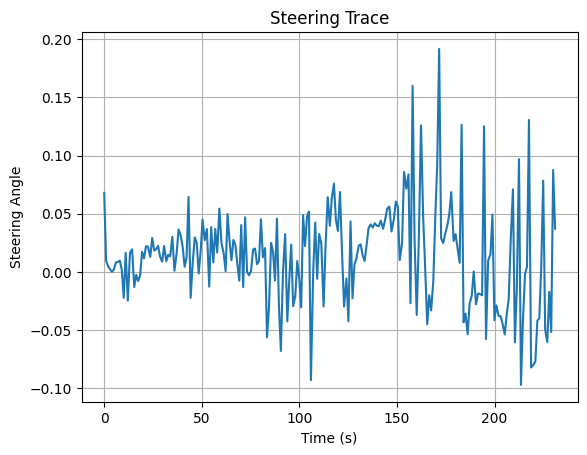

In [10]:
df = pd.read_csv("steering_trace_preci40 - Copy.csv")
plt.plot(df["timestamp"], df["steer"])
plt.xlabel("Time (s)")
plt.ylabel("Steering Angle")
plt.title("Steering Trace")
plt.grid()
plt.savefig('Steer trace - preci40.pdf', dpi=600)
plt.show()

### Plotting steer trace

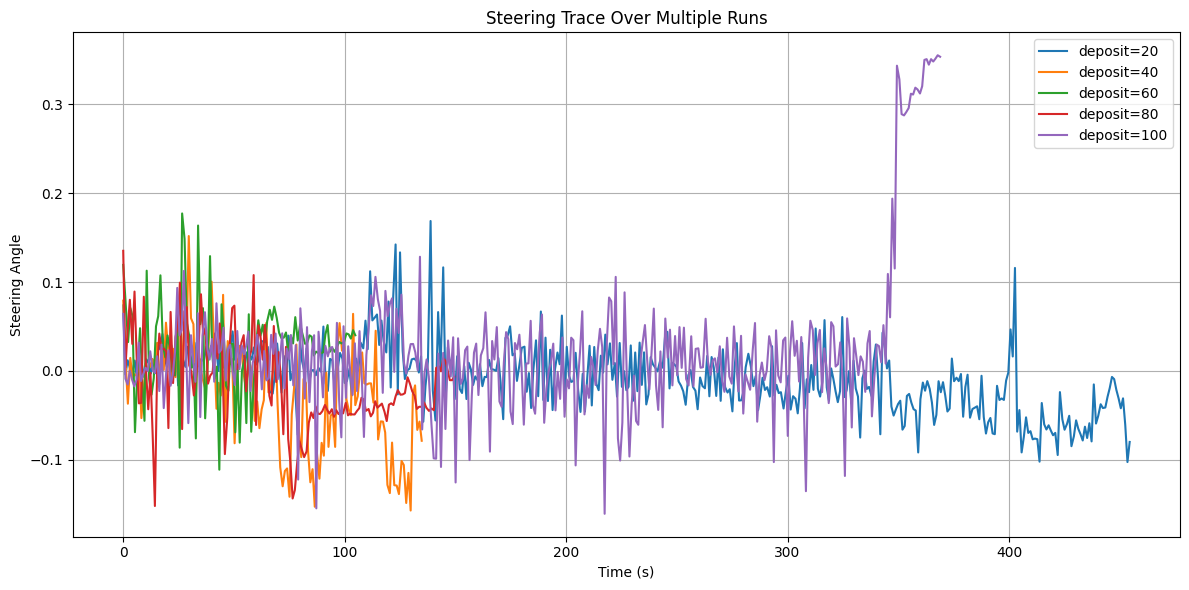

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# List of CSV files
csv_files = [
    "steering_trace_precideposit20.csv",
    "steering_trace_precideposit40.csv",
    "steering_trace_precideposit60.csv",
    "steering_trace_precideposit80.csv",
    "steering_trace_precideposit100.csv"
]

# Optional labels for the legend
labels = ["deposit=20", "deposit=40", "deposit=60", "deposit=80", "deposit=100"]

# Plot each file
plt.figure(figsize=(12, 6))
for csv_file, label in zip(csv_files, labels):
    df = pd.read_csv(csv_file)
    plt.plot(df["timestamp"], df["steer"], label=label)

# Customize the plot
plt.xlabel("Time (s)")
plt.ylabel("Steering Angle")
plt.title("Steering Trace Over Multiple Runs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('Steer trace - preci deposit all cases.pdf', dpi=600)
plt.show()